In [56]:
import neuronencodings as ne
from meshparty import mesh_io
import torch
import numpy as np
from neuroglancer_annotation_ui import interface, annotation
import importlib
from sklearn import decomposition, cluster
from matplotlib import pyplot as plt


interface.neuroglancer.server.global_server_args = dict(bind_address='localhost', bind_port=8888)

## Setting up

In [168]:
d = ne.data.fetch_dset_dirs("full_cells_refined")[0]
fs = ne.data.utils.files_from_dir(d)
n_pts = 1000

meshmeta = mesh_io.MeshMeta()

# chkpt_fname = "/usr/people/nturner/seungmount/research/nick_and_sven/models_sven/full_cells_ae_local_v6/models/model_97500.chkpt"
# state_dict = torch.load(chkpt_fname)

# del_keys = []
# for k in state_dict.keys():
#     if k.endswith("num_batches_tracked"):
#         del_keys.append(k)
        
# for k in del_keys:
#     del state_dict[k]

# model = ne.utils.load_autoencoder("PointNetAE", n_pts=n_pts, bottle_fs=64, state_dict=state_dict, bn=True, eval_=True)

chkpt_fname = "/usr/people/nturner/seungmount/research/nick_and_sven/models_nick/sven_repl/models/model_22500.chkpt"
model = ne.utils.load_autoencoder("PointNetAE", n_pts=1000, bottle_fs=64, chkpt_fname=chkpt_fname, eval_=True)

## Running inference

In [193]:
mesh = meshmeta.mesh(fs[0])

vectors = []
center_inds = []
for i in range(5):
    print(i)
    v, c = ne.pred.encode_mesh_by_views(model, mesh, n_points=1000, verbose=False, order="random", pc_align=True)
    vectors.extend(v)
    center_inds.extend(c)

0
1
2
3
4


In [194]:
center_inds = np.array(center_inds)
vectors = np.array(vectors)

In [195]:
len(np.unique(vectors, axis=0)), len(np.unique(center_inds))

(3198, 3211)

In [196]:
vectors.shape

(3246, 64)

## Visualization

In [197]:
def rgb2hex(r,g,b):
    hex = "#{:02x}{:02x}{:02x}".format(r,g,b)
    return hex

In [198]:
def get_point_annotations(points):
    return [annotation.point_annotation(point / np.array([4, 4, 40]), i) for i, point in enumerate(points)]

In [199]:
def get_pca_components(vectors, normed=True):
    n_components = 10
    features_n = np.array(vectors).copy()
    std = np.std(features_n, axis=0)[None]
    std[std == 0] = 1
    features_n /= std
    features_n -= np.nanmean(features_n, axis=0)[None]

    pca = decomposition.PCA(n_components=n_components)
    features_t = pca.fit_transform(features_n)
    print(pca.explained_variance_ratio_)
    
    if normed:
        features_t -= np.min(features_t, axis=0)
        features_t /= np.max(features_t, axis=0)
    return features_t

In [200]:
ngl_url = "neuromancer-seung-import.appspot.com"
image_source = "precomputed://gs://neuroglancer/pinky40_v11/image"
segmentation_source = "precomputed://gs://neuroglancer/pinky40_v11/watershed_mst_trimmed_sem_remap"
image_layer_name = "img"
segmentation_layer_name = "seg"

In [201]:
viewer = interface.Interface(ngl_url=ngl_url)
viewer.add_segmentation_layer(segmentation_layer_name, segmentation_source)
viewer.add_image_layer(image_layer_name, image_source)

In [202]:
with viewer.config_state.txn() as s:
    s.show_ui_controls = False

In [203]:
pv = get_pca_components(vectors)
pv_r = (pv[:, :3] * 3).astype(np.int).astype(np.float) / 3
u_pvs, i_pvs = np.unique(pv_r, axis=0, return_inverse=True)

[0.36870643 0.16580856 0.05074761 0.04928346 0.03653446 0.03554406
 0.03013325 0.02282313 0.02052063 0.01926568]


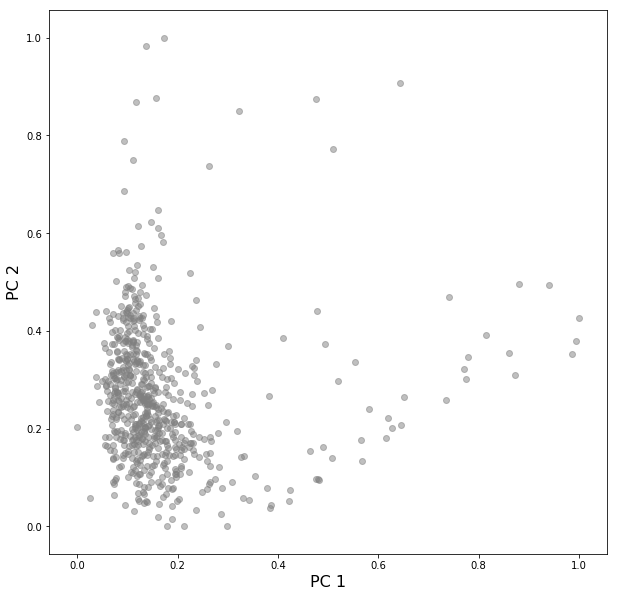

In [180]:
plt.figure(figsize=(10, 10))

axis=[0, 1]
plt.scatter(pv[:, 0], pv[:, 1], c=".5", alpha=.5) 

plt.xlabel("PC %d" % (axis[0] + 1), fontsize=16)
plt.ylabel("PC %d" % (axis[1] + 1), fontsize=16)

plt.show()

In [181]:
for i_pv, u_pv in enumerate(u_pvs):
    print("%d / %d" % (i_pv, len(u_pvs)))
    pt_annotations = get_point_annotations(mesh.vertices[center_inds[i_pvs == i_pv]])
    
    r, g, b = np.array(u_pv * 255, dtype=np.int)
    viewer.add_annotation(annotation=pt_annotations, layer_name="pts_%d" % i_pv, color=rgb2hex(r, g, b))

0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20


In [182]:
viewer

http://localhost:8888/v/aaebfcc7d50e3156db664856294a22a887d15b77/

In [165]:
n_clusters = 10
kmeans = cluster.KMeans(n_clusters=n_clusters, n_jobs=-1).fit(vectors)

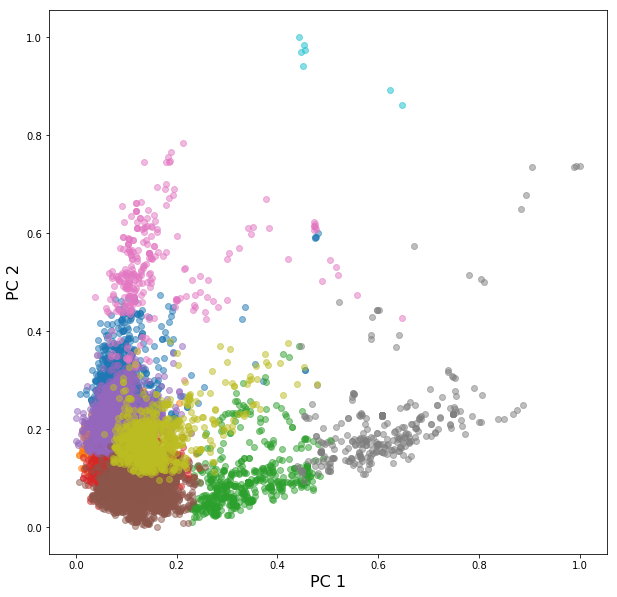

In [166]:
cm = plt.get_cmap('tab10')
colors = [cm(.05 + .1 * i) for i in range(n_clusters)]

plt.figure(figsize=(10, 10))

axis=[0, 1]
for i_cluster in range(n_clusters):
    m = kmeans.labels_ == i_cluster
    c = colors[i_cluster]
    plt.scatter(pv[m, 0], pv[m, 1], c=c, alpha=.5) 

plt.xlabel("PC %d" % (axis[0] + 1), fontsize=16)
plt.ylabel("PC %d" % (axis[1] + 1), fontsize=16)

plt.show()

In [167]:
for i_cluster in range(n_clusters):
    m = kmeans.labels_ == i_cluster
    c = np.array(np.array(list(colors[i_cluster])) * 255, dtype=np.int)[:3]
    
    pt_annotations = get_point_annotations(mesh.vertices[center_inds[m]])
    
    r, g, b = c
    viewer.add_annotation(annotation=pt_annotations, layer_name="pt_%d" % i_cluster, color=rgb2hex(r, g, b))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 12950 but corresponding boolean dimension is 13017

In [159]:
viewer

http://localhost:8888/v/26ba4d93d071ca571099826a1b67d97d02d9941c/

In [120]:
vectors_nick = vectors.copy()

In [160]:
vectors_sven = vectors.copy()

In [161]:
vectors = vectors_nick